<a href="https://colab.research.google.com/github/GMSantos4/dio_machine_learning_specialist/blob/main/dio_transfer_learning_desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Lidando com os dados

Inicialmente, utilizarei os dados presentes no pacote _torchvision_. O problema que buscarei resolver será o de ensinar ao modelo a classificar formigas e abelhas.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Pipeline de transformações realizadas no meu dado antes de enviá-lo para a CNN
# Observe que a variável "data_transform" é um dicionário python
data_transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),                                  # Definindo o tamanho dos lados das figuras
    transforms.RandomHorizontalFlip(),                                  # Deslizando a imagem horizontalmente
    transforms.ToTensor(),                                              # transformando a imagem num tensor (formato mais indicado para a entrada da CNN)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizando o tensor de imagens, os argumentos são a média e o desvio padrão dos tensores
])

data_transform_val = transforms.Compose([
    transforms.RandomResizedCrop(224),                                  # Definindo o tamanho dos lados das figuras
    transforms.RandomHorizontalFlip(),                                  # Deslizando a imagem horizontalmente
    transforms.ToTensor(),                                              # transformando a imagem num tensor (formato mais indicado para a entrada da CNN)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizando o tensor de imagens, os argumentos são a média e o desvio padrão dos tensores
])

In [19]:
# Carregando imagens e aplicando o pipeline definido em "data_transform_train" e "data_transform.val"
# "data_dir" é o caminho no diretório de onde meu arquivo está salvo
data_dir = "/content/drive/MyDrive/DIO/dio_transfer_learning/hymenoptera_data"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=data_transform_train)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=data_transform_val)

dataset_sizes = {
    'train':len(train_dataset),
    'val':len(val_dataset)
}

# Criando dataloaders, que são as variáveis que alimentarão minha CNN com os dados de treinamento
# Este procedimento faz parte do framework
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=4,
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=4,
                                             shuffle=True)
dataloaders = {
    'train':train_dataloader,
    'val':val_dataloader
}

# Definindo qual processador será utilizado para rodar meu aprendizado de máquina
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tamanho dos datasets e nome ddas features
train_dataset_size, val_dataset_size = (len(train_dataset), len(val_dataset))
class_names = train_dataset.classes
print(f'Size train dataset is {train_dataset_size}',
      f'Size val dataset is {val_dataset_size}',
      f'Features are {class_names}',
      sep='\n')

Size train dataset is 244
Size val dataset is 153
Features are ['ants', 'bees']


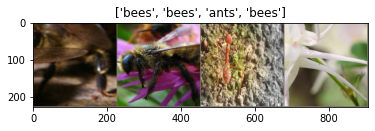

In [38]:
# Função copiada do tutorial para apresentação das imagens com seus rótulos
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 2 Treinando o Modelo

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# 3 Visualizando o modelo

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 4 _Transfer Learning_ da rede neural por _Finetuning_

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 5 Treinando o modelo

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4192 Acc: 0.8320
val Loss: 0.4703 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.4091 Acc: 0.8115
val Loss: 0.2462 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.6618 Acc: 0.7541
val Loss: 0.4812 Acc: 0.8105

Epoch 3/24
----------
train Loss: 0.3492 Acc: 0.8607
val Loss: 0.3358 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4866 Acc: 0.8730
val Loss: 0.4459 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.5050 Acc: 0.8320
val Loss: 0.3848 Acc: 0.8824

Epoch 6/24
----------


In [ ]:
visualize_model(model_ft)